In [1]:
import os
import cv2
import argparse
from sklearn.svm import LinearSVC
from skimage import feature
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt


In [2]:
train_image_paths = []
train_labels = []
# get all the image folder paths
Categories=['black widow', 'captain america', 'doctor strange', 'hulk', 'ironman', 'loki', 'spider-man', 'thanos']
datadir='dataset\\train' 

for i in Categories:
    
    print(f'loading... category : {i}')
    path=os.path.join(datadir,i)
    for img in os.listdir(path):
        train_image_paths.append(os.path.join(path,img))
        train_labels.append(Categories.index(i))
    print(f'loaded category:{i} successfully')

loading... category : black widow
loaded category:black widow successfully
loading... category : captain america
loaded category:captain america successfully
loading... category : doctor strange
loaded category:doctor strange successfully
loading... category : hulk
loaded category:hulk successfully
loading... category : ironman
loaded category:ironman successfully
loading... category : loki
loaded category:loki successfully
loading... category : spider-man
loaded category:spider-man successfully
loading... category : thanos
loaded category:thanos successfully


In [3]:
test_image_paths = []
test_labels = []
# get all the image folder paths
Categories=['black widow', 'captain america', 'doctor strange', 'hulk', 'ironman', 'loki', 'spider-man', 'thanos']
datadir='dataset\\test' 

for i in Categories:
    
    print(f'loading... category : {i}')
    path=os.path.join(datadir,i)
    for img in os.listdir(path):
        test_image_paths.append(os.path.join(path,img))
        test_labels.append(Categories.index(i))
    print(f'loaded category:{i} successfully')

loading... category : black widow
loaded category:black widow successfully
loading... category : captain america
loaded category:captain america successfully
loading... category : doctor strange
loaded category:doctor strange successfully
loading... category : hulk
loaded category:hulk successfully
loading... category : ironman
loaded category:ironman successfully
loading... category : loki
loaded category:loki successfully
loading... category : spider-man
loaded category:spider-man successfully
loading... category : thanos
loaded category:thanos successfully


In [4]:
import os

import cv2 as cv
import joblib
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from lab3_utils import get_image_paths
#from utils import *
from utils import read_img
SIFT_MAX_FEATURES = 300 #Change this parameter to 100, 200, 300 , 400 and delete this feature to perform the hyperparameter tuning

IMAGE_CATEGORIES = ['black widow', 'captain america', 'doctor strange', 'hulk', 'ironman', 'loki', 'spider-man', 'thanos']

def build_codebook(image_paths, num_tokens=150): #Change num_tokens to 8, 50, 100, 150, 200 to perform the hyperparameter tuning
    sift = cv.SIFT_create(nfeatures  = SIFT_MAX_FEATURES)
    container = []
    for image_path in image_paths:
        img = read_img(image_path, mono=True)
        keypoints, descriptors = sift.detectAndCompute(img, None)
        if descriptors is not None:
            container.append(descriptors)
    container = np.concatenate(container)
    print(container.shape)
    print('Training KMeans...')
    kmeans = KMeans(n_clusters=num_tokens)
    kmeans.fit(container)
    print('Done')
    return kmeans.cluster_centers_


def bag_of_words(image_paths, codebook):
    sift = cv.SIFT_create(nfeatures  = SIFT_MAX_FEATURES)
    codebook_size = codebook.shape[0]
    image_features = []
    for image_path in image_paths:
        img = read_img(image_path, mono=True)
        keypoints, descriptors = sift.detectAndCompute(img, None)
        bow = np.zeros(codebook_size)
        if descriptors is not None:
            distances = cdist(descriptors, codebook)
            for d in distances:
                bow[np.argmin(d)] += 1
        image_features.append(bow.reshape(1, codebook_size))
    image_features = np.concatenate(image_features)
    return image_features


if os.path.exists('Saved_Models_SVM/codebook_SIFT.joblib'):
    codebook = joblib.load('Saved_Models_SVM/codebook_SIFT.joblib')
else:
    codebook = build_codebook(train_image_paths)
    print('Persisting codebook...')
    joblib.dump(codebook, 'Saved_Models_SVM/codebook_SIFT.joblib')
    print('Done')

scaler = StandardScaler()

print('Generating BOW features for training set...')
train_images = bag_of_words(train_image_paths, codebook)
train_images_scaled = scaler.fit_transform(train_images)
print('Train images:', train_images.shape)

print('Generating BOW features for test set...')
test_images = bag_of_words(test_image_paths, codebook)
test_images_scaled = scaler.transform(test_images)
print('Test images:', test_images.shape)

if os.path.exists('Saved_Models_SVM/svm_bow_SIFT.joblib'):
    print('Loading existing linear SVM model...')
    svm = joblib.load('Saved_Models_SVM/svm_bow_SIFT.joblib')
else:
    print('Training a linear SVM...')
    svm = SVC(gamma='scale')
    svm.fit(train_images_scaled, train_labels)
    joblib.dump(svm, 'Saved_Models_SVM/svm_bow_SIFT.joblib')
print('Done')



Generating BOW features for training set...
Train images: (2325, 150)
Generating BOW features for test set...
Test images: (451, 150)
Loading existing linear SVM model...
Done


In [5]:
test_predictions = svm.predict(test_images_scaled)
accuracy = accuracy_score(test_labels, test_predictions)
print('Classification accuracy of SVM with BOW and SIFT features:', accuracy)

Classification accuracy of SVM with BOW and SIFT features: 0.2660753880266075


In [6]:
from sklearn.metrics import f1_score
f1_score(test_labels, test_predictions, average='macro')

0.26056000856311634

In [10]:
import helper

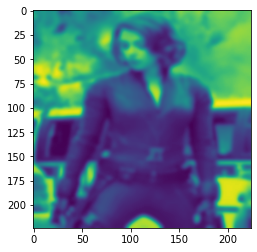

In [14]:

img = read_img("dataset/test/black widow/pic_005.jpg", mono=True)
img_blur = helper.gaussian_blur(img, 8)

plt.imshow(img_blur)